In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re

In [70]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
            except:
                pass
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [71]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [72]:
experiment_logs = './results/booking_config_2021_01_18T07_46_55/stdout'
data = get_data_from_logs(experiment_logs, 0)


In [73]:
df = pd.DataFrame(data).set_index('model_name').sort_values('SPS@4')
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
APREC-GMLPHE-Lambdarank-256-0.7,0.11050,0.442,0.350880,0.430380,3121.758222,32.767731,"{'epochs_trained': 24, 'best_val_ndcg': 0.4266...","[{'loss': 2.7539, 'ndcg_at_40': 0.08, 'Success..."
APREC-GMLPHE-Lambdarank-256-0.5,0.11150,0.446,0.357683,0.441915,3086.711028,32.164629,"{'epochs_trained': 23, 'best_val_ndcg': 0.4341...","[{'loss': 2.8282, 'ndcg_at_40': 0.0753, 'Succe..."
APREC-GMLPHE-Lambdarank-256-0.0,0.11150,0.446,0.356689,0.433985,3308.944663,33.414050,"{'epochs_trained': 29, 'best_val_ndcg': 0.4261...","[{'loss': 2.737, 'ndcg_at_40': 0.0763, 'Succes..."
APREC-GMLPHE-Lambdarank-256-0.9,0.11175,0.447,0.353536,0.433232,3490.325851,32.723745,"{'epochs_trained': 29, 'best_val_ndcg': 0.4385...","[{'loss': 2.9264, 'ndcg_at_40': 0.0811, 'Succe..."
APREC-GMLPHE-Lambdarank-256-1,0.11175,0.447,0.353179,0.434425,2738.770549,36.072141,"{'epochs_trained': 20, 'best_val_ndcg': 0.4445...","[{'loss': 2.8032, 'ndcg_at_40': 0.0783, 'Succe..."
APREC-GMLPHE-Lambdarank-256-0.3,0.11300,0.452,0.361190,0.441629,3709.127559,32.152584,"{'epochs_trained': 32, 'best_val_ndcg': 0.4459...","[{'loss': 2.7696, 'ndcg_at_40': 0.0793, 'Succe..."
APREC-GMLPHE-Lambdarank-256-0.1,0.11350,0.454,0.356497,0.434773,3091.564604,33.651833,"{'epochs_trained': 24, 'best_val_ndcg': 0.4563...","[{'loss': 2.7865, 'ndcg_at_40': 0.0814, 'Succe..."


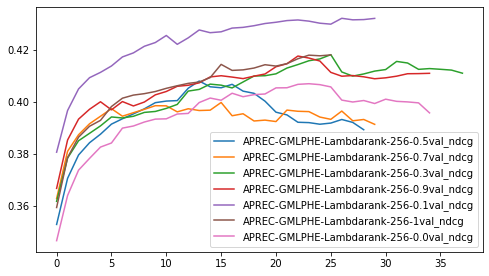

In [74]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(8, 4.5))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = get_metric(history, 'val_ndcg_at_40')
        
        success = get_metric(history, 'Success_at_4')
        val_success = get_metric(history, 'val_Success_at_4')
        
        plt.plot(moving_average(val_ndcg, 15), label=recommender['model_name'] + "val_ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [75]:
df['target_decay'] = [float(name.split('-')[-1]) for name in  list(df.index)]

In [76]:
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history,target_decay
model_name,,,,,,,,,
APREC-GMLPHE-Lambdarank-256-0.7,0.11050,0.442,0.350880,0.430380,3121.758222,32.767731,"{'epochs_trained': 24, 'best_val_ndcg': 0.4266...","[{'loss': 2.7539, 'ndcg_at_40': 0.08, 'Success...",0.7
APREC-GMLPHE-Lambdarank-256-0.5,0.11150,0.446,0.357683,0.441915,3086.711028,32.164629,"{'epochs_trained': 23, 'best_val_ndcg': 0.4341...","[{'loss': 2.8282, 'ndcg_at_40': 0.0753, 'Succe...",0.5
APREC-GMLPHE-Lambdarank-256-0.0,0.11150,0.446,0.356689,0.433985,3308.944663,33.414050,"{'epochs_trained': 29, 'best_val_ndcg': 0.4261...","[{'loss': 2.737, 'ndcg_at_40': 0.0763, 'Succes...",0.0
APREC-GMLPHE-Lambdarank-256-0.9,0.11175,0.447,0.353536,0.433232,3490.325851,32.723745,"{'epochs_trained': 29, 'best_val_ndcg': 0.4385...","[{'loss': 2.9264, 'ndcg_at_40': 0.0811, 'Succe...",0.9
APREC-GMLPHE-Lambdarank-256-1,0.11175,0.447,0.353179,0.434425,2738.770549,36.072141,"{'epochs_trained': 20, 'best_val_ndcg': 0.4445...","[{'loss': 2.8032, 'ndcg_at_40': 0.0783, 'Succe...",1.0
APREC-GMLPHE-Lambdarank-256-0.3,0.11300,0.452,0.361190,0.441629,3709.127559,32.152584,"{'epochs_trained': 32, 'best_val_ndcg': 0.4459...","[{'loss': 2.7696, 'ndcg_at_40': 0.0793, 'Succe...",0.3
APREC-GMLPHE-Lambdarank-256-0.1,0.11350,0.454,0.356497,0.434773,3091.564604,33.651833,"{'epochs_trained': 24, 'best_val_ndcg': 0.4563...","[{'loss': 2.7865, 'ndcg_at_40': 0.0814, 'Succe...",0.1


In [77]:
df_sorted = df.sort_values('target_decay')

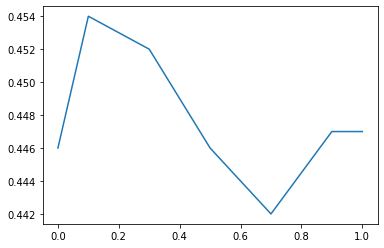

In [78]:
plt.plot(df_sorted['target_decay'], df_sorted['SPS@4'])